## **Hexaboard Visual Inspection**

In [1]:
# --- Default libraries ---
import os
import warnings
from pathlib import Path

# --- Working directory ---
PROJECT_DIR = Path().resolve()
PROJECT_ROOT_NAME = 'visual-inspection'

while PROJECT_DIR.name != PROJECT_ROOT_NAME and PROJECT_DIR != PROJECT_DIR.parent:
    PROJECT_DIR = PROJECT_DIR.parent

if Path().resolve() != PROJECT_DIR:
    os.chdir(PROJECT_DIR)

DATA_DIR = PROJECT_DIR / 'data'
LOG_DIR = PROJECT_DIR / 'logs'

# --- Data preprocessing & visualization ---
import numpy as np

# --- Deep learning ---
import torch
from torch import nn, optim
from torchvision import transforms

# --- Custom modules ---
from src.configs import TrainConfig
from src.engine import AutoencoderTrainer
from src.models import ResNetAutoencoder
from src.utils import EarlyStopping
from src.utils.data import HexaboardDataset
from src.utils.viz import *

# --- Settings ---
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1. Data Processing**

(13, 9, 1016, 1640, 3)


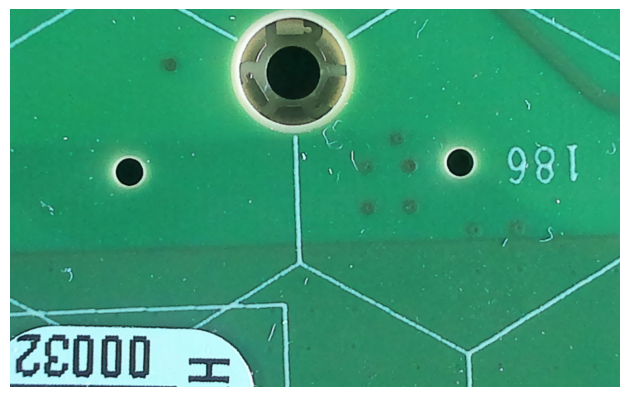

In [2]:
# Read the image
image = np.load(DATA_DIR / 'train' / 'aligned_images1.npy')

# Convert BGR to RGB
image = image[..., ::-1]
print(image.shape)

# Visualize segments
visualize_segments(
    data=image,
    num_samples=1,
    randomize=True
)

In [3]:
# Convert np.ndarray to torch.Tensor: (H, W, C) -> (C, H, W)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the hexaboard datasets
train_dataset = HexaboardDataset(root=DATA_DIR / 'train', transform=transform)
val_dataset = HexaboardDataset(root=DATA_DIR / 'val', transform=transform)
test_dataset = HexaboardDataset(root=DATA_DIR / 'test', transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 720
Validation dataset size: 90
Test dataset size: 90


### **2. Train the Model**

In [ ]:
# Initialize the model
model = ResNetAutoencoder(
    height=train_dataset.height,
    width=train_dataset.width,
    latent_dim=16,
    init_filters=32,
    layers=[2, 2, 2]
).to(device)
model

ResNetAutoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder_layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, t

In [5]:
# Count parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params

191744

In [6]:
# Training configurations
train_config = TrainConfig(
    batch_size=8,
    num_epochs=30,
    start_epoch=0,
    logging_dir=str(LOG_DIR),
    logging_steps=10,
    save_best=True,
    save_ckpt=True,
    device='cuda',
    num_workers=0,
    pin_memory=True
)

In [ ]:
# Intialize the trainer
learning_rate = 1e-3
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5)
trainer = AutoencoderTrainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=[callbacks],
    config=train_config
)

In [8]:
# Train the model
history, model = trainer.train()

Training:   0%|          | 0/2700 [00:00<?, ?it/s]

step: 10/2700 | train_loss: 0.6854
step: 20/2700 | train_loss: 0.6552
step: 30/2700 | train_loss: 0.6397
step: 40/2700 | train_loss: 0.6278
step: 50/2700 | train_loss: 0.6201
step: 60/2700 | train_loss: 0.6142
step: 70/2700 | train_loss: 0.6106
step: 80/2700 | train_loss: 0.6078
step: 90/2700 | train_loss: 0.6054
epoch: 1/30 | val_loss: 0.5781
step: 100/2700 | train_loss: 0.5926
step: 110/2700 | train_loss: 0.5906
step: 120/2700 | train_loss: 0.5885
step: 130/2700 | train_loss: 0.5874
step: 140/2700 | train_loss: 0.5864
step: 150/2700 | train_loss: 0.5859
step: 160/2700 | train_loss: 0.5855
step: 170/2700 | train_loss: 0.5854
step: 180/2700 | train_loss: 0.5849
epoch: 2/30 | val_loss: 0.5731
step: 190/2700 | train_loss: 0.5851
step: 200/2700 | train_loss: 0.5839
step: 210/2700 | train_loss: 0.5843
step: 220/2700 | train_loss: 0.5830
step: 230/2700 | train_loss: 0.5834
step: 240/2700 | train_loss: 0.5826
step: 250/2700 | train_loss: 0.5826
step: 260/2700 | train_loss: 0.5823
step: 270/2

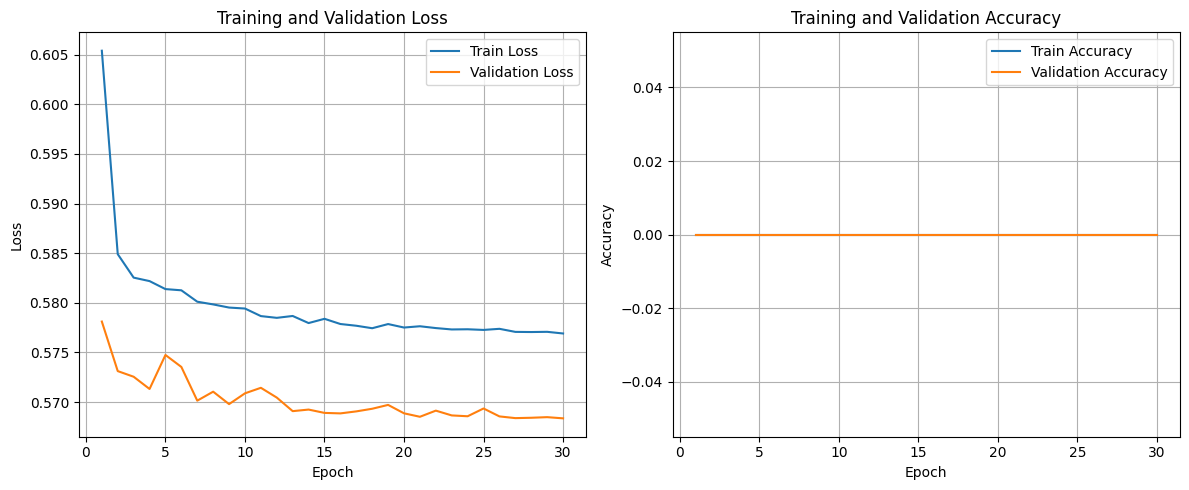

In [9]:
# Visualize training history
plot_history(history)

In [ ]:
# Load the best model
model_path = trainer.best_model_path
model_path = str(LOG_DIR / model.__class__.__name__ / 'best' / 'run_01.pt')
trainer.load_best_model(model_path)

In [ ]:
# Evaluate the model on the test set (a good example)
test_loss_good, y_true_good, y_pred_good = trainer.evaluate()

test_loss: 0.5732


In [11]:
# Evaluate the model on a bad example
from torch.utils.data import DataLoader

bad_dataset = HexaboardDataset(root=DATA_DIR / 'bad_example', transform=transform)
trainer.test_loader = DataLoader(
    dataset=bad_dataset,
    batch_size=train_config.batch_size,
    shuffle=False,
    num_workers=train_config.num_workers,
    pin_memory=train_config.pin_memory
)
test_loss_bad, y_true_bad, y_pred_bad = trainer.evaluate()

test_loss: 0.5755


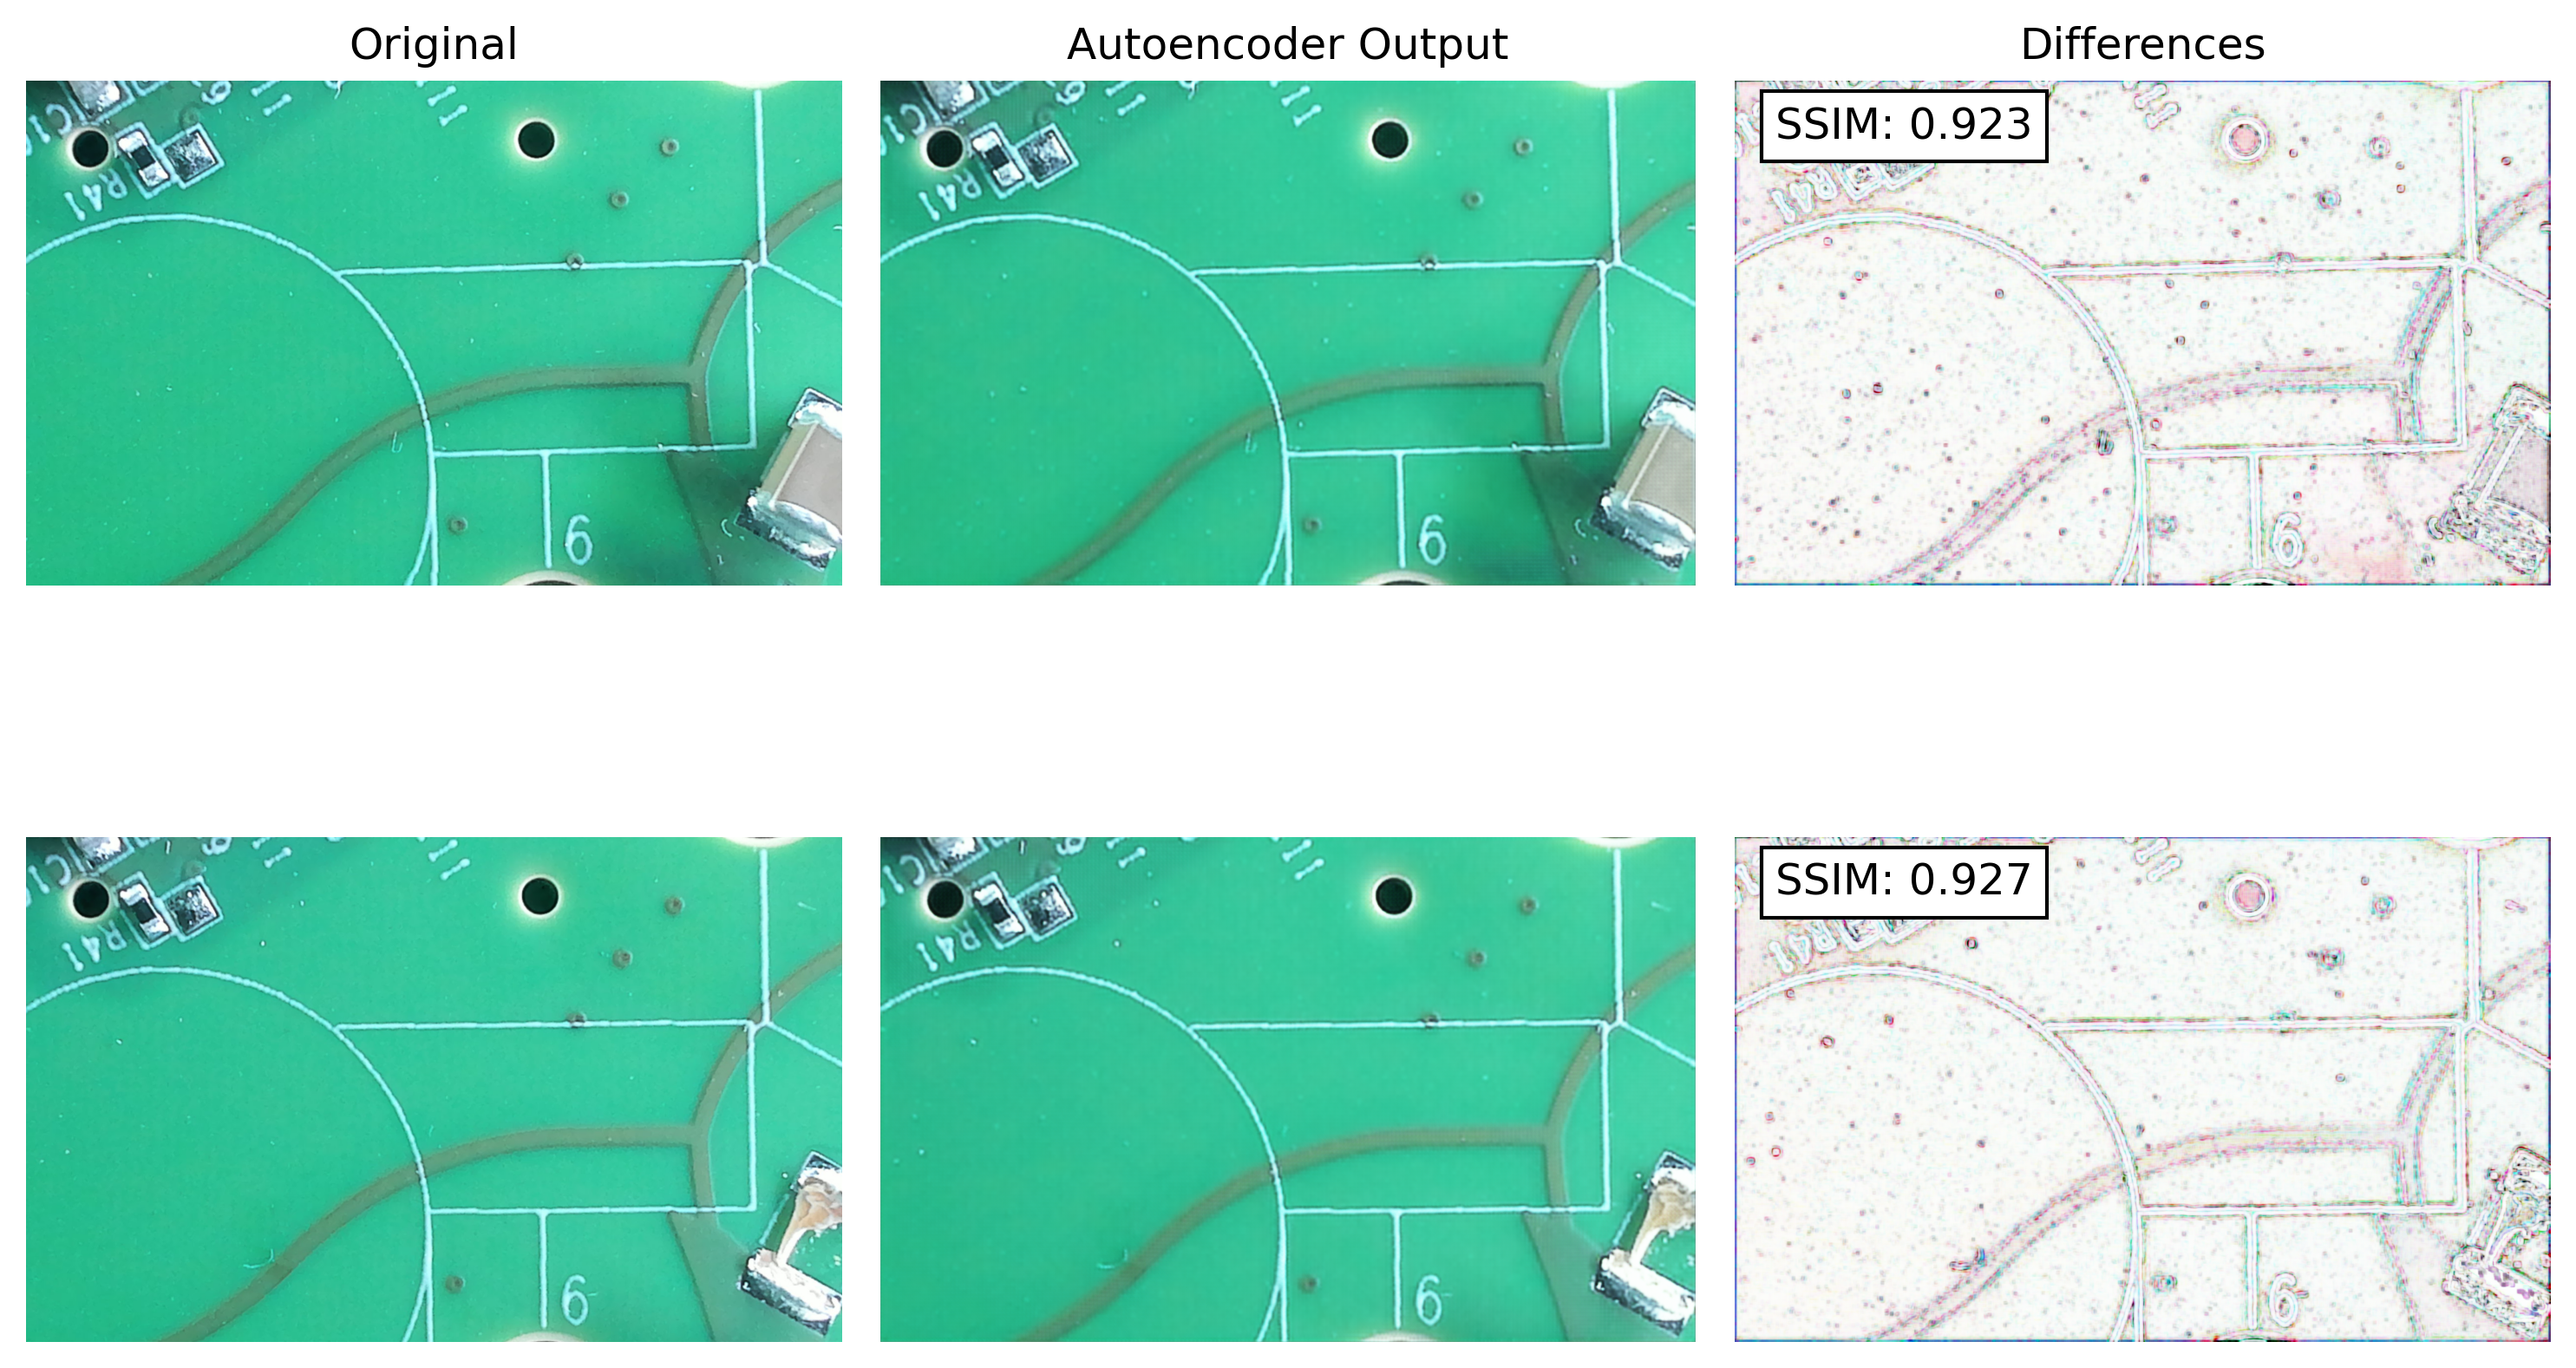

In [ ]:
# Visualize the comparison
plot_ae_comparison(
    y_true_good=y_true_good,
    y_pred_good=y_pred_good,
    y_true_bad=y_true_bad,
    y_pred_bad=y_pred_bad,
    segment_idx=83
)